In [1]:
!pip install https://s3-us-west-2.amazonaws.com/ai2-s2-scispacy/releases/v0.2.4/en_ner_bc5cdr_md-0.2.4.tar.gz

  Using cached https://s3-us-west-2.amazonaws.com/ai2-s2-scispacy/releases/v0.2.4/en_ner_bc5cdr_md-0.2.4.tar.gz (70.1 MB)
  Created wheel for en-ner-bc5cdr-md: filename=en_ner_bc5cdr_md-0.2.4-py3-none-any.whl size=70531464 sha256=22e64d19c527d646e377db9b48c2b14c9a30d43db3dada9ca1aa799c8eafccf0
  Stored in directory: /Users/patsnap/Library/Caches/pip/wheels/7c/f4/2d/75a2d2f28a86df956116d40993f5f81df5f5522665c89230eb
Successfully built en-ner-bc5cdr-md


In [2]:
%%bash -e
if ! [[ -f ./xyz2mol.py ]]; then
  wget https://raw.githubusercontent.com/jensengroup/xyz2mol/master/xyz2mol.py
fi

In [3]:
!pip install py3Dmol
!pip install -U chembl_webresource_client
import sys
# !conda install --yes --prefix {sys.prefix} -c rdkit rdkit

Requirement already up-to-date: chembl_webresource_client in /Users/patsnap/anaconda2/lib/python3.7/site-packages (0.10.1)


In [32]:
import glob
import json
import pandas as pd
import pickle
import spacy
from spacy import displacy
from spacy.matcher import Matcher
from tqdm import tqdm
import en_ner_bc5cdr_md
import os
from collections import Counter
import matplotlib.pyplot as plt
from chembl_webresource_client.new_client import new_client
# import rdkit
# from rdkit import Chem
# from rdkit.Chem import Draw
import py3Dmol # Amazing library for 3D visualization
# from rdkit import Chem
# from rdkit.Chem import AllChem
from ipywidgets import interact, interactive, fixed
from IPython.display import Image
import cv2
import numpy as np
from mpl_toolkits.mplot3d import Axes3D
from sklearn import decomposition
from sklearn import datasets
from sklearn.cluster import KMeans
import gc

In [5]:
def doi_to_url(doi):
    if isinstance(doi, float):
        return None
    elif doi.startswith('http'):
        return str(doi)
    elif doi.startswith('doi'):
        return 'https://' + str(doi)
    else:
        return 'https://doi.org/' + str(doi)

In [6]:
df_meta = pd.read_csv('/Users/patsnap/Desktop/Neo4J_and_other_codes/Coronavirus_19/CORD-19-research-challenge/metadata.csv')
df_meta['url'] = df_meta.doi.apply(doi_to_url)
df_meta.head(3)

,cord_uid,sha,source_x,title,doi,pmcid,pubmed_id,license,abstract,publish_time,authors,journal,Microsoft Academic Paper ID,WHO #Covidence,has_pdf_parse,has_pmc_xml_parse,full_text_file,url
0,xqhn0vbp,1e1286db212100993d03cc22374b624f7caee956,PMC,Airborne rhinovirus detection and effect of ul...,10.1186/1471-2458-3-5,PMC140314,12525263.0,no-cc,"BACKGROUND: Rhinovirus, the most common cause ...",2003-01-13,"Myatt, Theodore A; Johnston, Sebastian L; Rudn...",BMC Public Health,NaN,NaN,True,True,custom_license,https://doi.org/10.1186/1471-2458-3-5
1,gi6uaa83,8ae137c8da1607b3a8e4c946c07ca8bda67f88ac,PMC,Discovering human history from stomach bacteria,10.1186/gb-2003-4-5-213,PMC156578,12734001.0,no-cc,Recent analyses of human pathogens have reveal...,2003-04-28,"Disotell, Todd R",Genome Biol,NaN,NaN,True,True,custom_license,https://doi.org/10.1186/gb-2003-4-5-213
2,le0ogx1s,NaN,PMC,A new recruit for the army of the men of death,10.1186/gb-2003-4-7-113,PMC193621,12844350.0,no-cc,"The army of the men of death, in John Bunyan's...",2003-06-27,"Petsko, Gregory A",Genome Biol,NaN,NaN,False,True,custom_license,https://doi.org/10.1186/gb-2003-4-7-113


In [7]:
data_path = '/Users/patsnap/Desktop/Neo4J_and_other_codes/Coronavirus_19/CORD-19-research-challenge'
json_files = glob.glob('/Users/patsnap/Desktop/Neo4J_and_other_codes/Coronavirus_19/CORD-19-research-challenge/biorxiv_medrxiv/biorxiv_medrxiv/**/*.json', recursive=True)
len(json_files)

13639

In [9]:
def to_covid_json(json_files):
    jsonl = []
    for file_name in tqdm(json_files):
        row = {"doc_id": None, "title": None, "abstract": None, "body": None}

        with open(file_name) as json_data:
            data = json.load(json_data)

            row['doc_id'] = data['paper_id']
            row['title'] = data['metadata']['title']
            
            abstract_list = [abst['text'] for abst in data['abstract']]
            abstract = "\n".join(abstract_list)
            row['abstract'] = abstract

            # And lastly the body of the text. 
            body_list = [bt['text'] for bt in data['body_text']]
            body = "\n".join(body_list)
            row['body'] = body
            
        jsonl.append(row)
    
    return jsonl
    

def get_data():
    try:
        with open('df_cache.pickle', 'rb') as f:
            df = pickle.load(f)
    except FileNotFoundError:
        df = pd.DataFrame(to_covid_json(json_files))
        with open('df_cache.pickle', 'wb') as f:
            pickle.dump(df, f)
    return df

df = get_data()
print(df.shape)
df.head(3)

100%|██████████| 13639/13639 [00:27<00:00, 505.06it/s]


(13639, 4)


,doc_id,title,abstract,body
0,f905f78b32f63c6d14a79984dfb33f1b358b8ab4,Multimerization of HIV-1 integrase hinges on c...,New anti-AIDS treatments must be continually d...,"In the absence of a curative treatment, the hi..."
1,607e0074d8ff40c272b958c2fe48793fedfc785e,Virus shedding patterns in nasopharyngeal and ...,,"the author/funder, who has granted medRxiv a l..."
2,7cfaa2540d3c8eea0982b3b1147884f125f67ff2,Non-neural expression of SARS-CoV-2 entry gene...,Recent reports suggest an association between ...,SARS-CoV-2 (CoV-2) is a pandemic coronavirus t...


In [10]:
df.describe()

,doc_id,title,abstract,body
count,13639,13639,13639,13639
unique,13639,12527,11512,13428
top,30b4defc3cb6deb9e7b1a2719d0537ca01081159,,,Coronaviruses are a group of enveloped viruses...
freq,1,729,1919,3


In [11]:
def no_title(row):
    return not row.title.strip()

def no_abstract(row):
    return not row.abstract.strip()

def no_body(row):
    return not row.body.strip()

def no_title_abstract_body(row):
    return no_title(row) and no_abstract(row) and no_body(row)

mask = df.apply(no_title_abstract_body, axis=1)
print('Number of articles that have no text data at all:', df.loc[mask].shape[0])

Number of articles that have no text data at all: 0


In [12]:
# insert missing values for empty strings
df.loc[df.apply(no_title, axis=1), 'title'] = None
df.loc[df.apply(no_abstract, axis=1), 'abstract'] = None
df.loc[df.apply(no_body, axis=1), 'body'] = None
df.head(3)

,doc_id,title,abstract,body
0,f905f78b32f63c6d14a79984dfb33f1b358b8ab4,Multimerization of HIV-1 integrase hinges on c...,New anti-AIDS treatments must be continually d...,"In the absence of a curative treatment, the hi..."
1,607e0074d8ff40c272b958c2fe48793fedfc785e,Virus shedding patterns in nasopharyngeal and ...,None,"the author/funder, who has granted medRxiv a l..."
2,7cfaa2540d3c8eea0982b3b1147884f125f67ff2,Non-neural expression of SARS-CoV-2 entry gene...,Recent reports suggest an association between ...,SARS-CoV-2 (CoV-2) is a pandemic coronavirus t...


In [13]:
print('Missing value counts by column')
len(df) - df.count()

Missing value counts by column


doc_id         0
title        729
abstract    1919
body           0
dtype: int64

In [14]:
# Gabarge collector
import gc
gc.collect()

20

In [15]:
df = df.dropna(subset=['abstract'])
print('DataFrame shape:', df.shape)
len(df) - df.count()

DataFrame shape: (11720, 4)


doc_id        0
title       301
abstract      0
body          0
dtype: int64

In [16]:
covid19_names = {
    'COVID19',
    'COVID-19',
    '2019-nCoV',
    '2019-nCoV.',
#     'novel coronavirus',  # too ambiguous, may mean SARS-CoV
    'coronavirus disease 2019',
    'Corona Virus Disease 2019',
    '2019-novel Coronavirus',
    'SARS-CoV-2',
}

def has_covid19(text):
    for name in covid19_names:
        if text and name.lower() in text.lower():
            return True
    return False

df['title_has_covid19'] = df.title.apply(has_covid19)
df['abstract_has_covid19'] = df.abstract.apply(has_covid19)
# df['body_has_covid19'] = df.body.apply(has_covid19)
df_covid19 = df[df.title_has_covid19 | df.abstract_has_covid19]
print(df_covid19.shape)

(1164, 6)


In [17]:
example_text = """
Unfortunately, no drug or vaccine has yet been approved to treat human coronaviruses. Several options can be envisaged to control or prevent emerging infections of 2019-nCoV, including vaccines, monoclonal antibodies, oligonucleotide-based therapies, peptides, interferon therapies and small-molecule drugs. However, new interventions are likely to require months to years to develop. Given the urgency of the 2019-nCoV outbreak, we focus here on the potential to repurpose existing antiviral agents approved or in development for treating infections caused by HIV, hepatitis B virus (HBV), hepatitis C virus (HCV) and influenza1, based on therapeutic experience with two other infections caused by human coronaviruses: severe acute respiratory syndrome (SARS) and Middle East respiratory syndrome (MERS).
Virally targeted agents. Approved nucleoside analogues (favipiravir and ribavirin) and experimental nucleoside analogues (remdesivir and galidesivir) may have potential against 2019-nCoV. Nucleoside analogues in the form of adenine or guanine derivatives target the RNA-dependent RNA polymerase and block viral RNA synthesis in a broad spectrum of RNA viruses, including human coronaviruses4. Favipiravir (T-705), a guanine analogue approved for influenza treatment, can effectively inhibit the RNA-dependent RNA polymerase of RNA viruses such as influenza, Ebola, yellow fever, chikungunya, norovirus and enterovirus4, and a recent study reported its activity against 2019-nCoV (EC50 = 61.88 μM in Vero E6 cells)5. Patients with 2019-nCoV are being recruited in randomized trials to evaluate the efficacy of favipiravir plus interferon-α (ChiCTR2000029600) and favipiravir plus baloxavir marboxil (an approved influenza inhibitor targeting the cap-dependent endonuclease) (ChiCTR2000029544). Ribavirin is a guanine derivative approved for treating HCV and respiratory syncytial virus (RSV) that has been evaluated in patients with SARS and MERS, but its side effects such as anaemia may be severe at high doses2 and whether it offers sufficient potency against 2019-nCoV is uncertain. Remdesivir (GS-5734) is a phosphoramidate prodrug of an adenine derivative with a chemical structure similar to that of tenofovir alafenamide, an approved HIV reverse transcriptase inhibitor. Remdesivir has broad-spectrum activities against RNA viruses such as MERS and SARS in cell cultures and animal models, and has been tested in a clinical trial for Ebola. A recent study reported that remdesivir inhibited 2019-nCoV (EC50 = 0.77 μM in Vero E6 cells)5, and a US patient with 2019-nCoV recovered after receiving intravenous remdesivir in January6. Two phase III trials were initiated in early February to evaluate intravenous remdesivir (200 mg on day 1 and 100 mg once daily for 9 days) in patients with 2019-nCoV (NCT04252664 and NCT04257656), with estimated completion dates in April 2020. Galidesivir (BCX4430), an adenosine analogue that was originally developed for HCV, is currently in early-stage clinical studies evaluating its safety in healthy subjects and its efficacy against yellow fever, and has shown antiviral activities in preclinical studies against many RNA viruses, including SARS and MERS2.
"""

In [18]:
nlp = en_ner_bc5cdr_md.load()
# nlp = spacy.load('../input/scispacy-model/en_ner_bc5cdr_md-0.2.4/en_ner_bc5cdr_md/en_ner_bc5cdr_md-0.2.4')

In [19]:
doc = nlp(example_text)

In [20]:
colors = {
    'CHEMICAL': 'lightpink',
    'DISEASE': 'lightorange',
}
displacy.render(doc, style='ent', options={
    'colors': colors
})


In [21]:
def apply_spacy(texts, nlp):
    docs = []
    for t in texts:
        if t:
            docs.append(nlp(t))
        else:
            docs.append(None)
    return docs

In [22]:
def annotate_with_spacy(df):
    df['title_doc'] = apply_spacy(df.title, nlp)
    df['abstract_doc'] = apply_spacy(df.abstract, nlp)
    return df

def get_spacy_df(df):
    try:
        with open('df_spacy_cache.pickle', 'rb') as f:
            df_spacy = pickle.load(f)
    except FileNotFoundError:
        df_spacy = annotate_with_spacy(df)
        with open('df_spacy_cache.pickle', 'wb') as f:
            pickle.dump(df_spacy, f)
    return df_spacy

In [23]:
df_spacy = get_spacy_df(df_covid19)
df_spacy.iloc[0].abstract_doc.ents

/Users/patsnap/anaconda2/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/Users/patsnap/anaconda2/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


(COVID-19,
 infection,
 SARS-CoV-2,
 CoV-2,
 CoV-2,
 CoV-2 infection,
 anosmia,
 olfactory dysfunction)

In [24]:
trial_indicators = {
    'trial',
    'study',
    'experiment',
    'evaluate',
    'evaluation',
    're-evaluate',
    'report',
    'test',
    'testing',
    'target',
    'data',
    'show',
    'outcome',
    'evaluation',
    'find',
    'agent',
    
}

usage_indicators = {
    'approve',
    'approval',
    'therapeutic',
    'therapy',
    'inhibitory',
    'effect',
    'administer',
    'achieve',
    'improve'
    'alleviate',
    'reduce',
    'antiviral',
    'against',
    'suppress',
    'beneficial',
    'evidence',
    'take',
    'prescribe',
    'treatment',
    'receive',
    'treat',
    'regimen',
    'therapy',
    'use',
    'efficacy',
    'course',
    'drug',
}

idea_indicators = {
    'promising',
    'promise',
    'speculate',
    'believe',
    'would',
    'could',
    'may',
    'possibly',
    'might',
    'should',
    'hypothesize',
    'appear',
    'lack',
    'unclear',
    'need',
} 

matcher = Matcher(nlp.vocab)
for n in trial_indicators:
    matcher.add("trial", None, [{'LEMMA': w.lemma_} for w in nlp(n)])
for n in usage_indicators:
    matcher.add("usage", None, [{'LEMMA': w.lemma_} for w in nlp(n)])
for n in idea_indicators:
    matcher.add("idea", None, [{'LEMMA': w.lemma_} for w in nlp(n)])

example_sent = "Clinical trials (for example, ChiCTR2000029539) have been initiated to test HIV protease inhibitors such as lopinavir and ritonavir in patients infected with 2019-nCoV."
doc = nlp(example_sent)
matches = matcher(doc)
for match_name, start, end in matches:
    print(nlp.vocab.strings[match_name], ':', doc[start:end])

trial : trials
trial : test


In [25]:
def doc_to_matches(doc):
    match_results = {
        'trial': [],
        'usage': [],
        'idea': []
    }
    if not doc:
        return match_results

    matches = matcher(doc)
    for match_id, start, end in matches:
        match_name = nlp.vocab.strings[match_id]
        match_results[match_name].append((start, end))
    return match_results

def get_matches_df(docs):
    matches = []
    for doc in docs:
        matches.append(doc_to_matches(doc))
    df = pd.DataFrame(matches)
    return df
        
df_matches = get_matches_df(df_spacy.abstract_doc)
df_matches.columns = ['abstract_trial_matches', 'abstract_usage_matches', 'abstract_idea_matches']
df_with_matches = pd.concat([df_spacy.reset_index(drop=True), df_matches], axis=1)
df_with_matches.head(3)

,doc_id,title,abstract,body,title_has_covid19,abstract_has_covid19,title_doc,abstract_doc,abstract_trial_matches,abstract_usage_matches,abstract_idea_matches
0,7cfaa2540d3c8eea0982b3b1147884f125f67ff2,Non-neural expression of SARS-CoV-2 entry gene...,Recent reports suggest an association between ...,SARS-CoV-2 (CoV-2) is a pandemic coronavirus t...,True,True,"(Non-neural, expression, of, SARS-CoV-2, entry...","(Recent, reports, suggest, an, association, be...","[(1, 2), (43, 44), (48, 49)]","[(99, 100)]","[(111, 112)]"
1,9bbfd3d34ee18ea1b9f4669331a6cee9c5992893,Virological assessment of hospitalized cases o...,"emerged in late 2019 1,2 . Initial outbreaks i...",Pharyngeal virus shedding was very high during...,True,True,"(Virological, assessment, of, hospitalized, ca...","(emerged, in, late, 2019, 1,2, ., Initial, out...","[(85, 86)]","[(22, 23)]","[(112, 113)]"
2,1218f278a4f8d83dac14b23c8f698062812ef9d5,Potential impact of seasonal forcing on a SARS...,A novel coronavirus (SARS-CoV-2) first detecte...,(2.2 with 90% high density interval 1.4-3.8 (R...,True,True,"(Potential, impact, of, seasonal, forcing, on,...","(A, novel, coronavirus, (, SARS-CoV-2, ), firs...","[(48, 49), (71, 72), (75, 76), (105, 106), (12...","[(103, 104), (217, 218), (232, 233)]","[(65, 66), (187, 188), (214, 215)]"


In [26]:
# df_covid19 = df_with_matches[df_with_matches.abstract_has_covid19]
print('Example abstracts', df_with_matches.shape)
for i, row in list(df_with_matches.iterrows())[:5]:
    print('TITLE:', row.title)
    print('\n')
    print(row.abstract)
    print('\n', '-' * 50, '\n')

Example abstracts (1164, 11)
TITLE: Non-neural expression of SARS-CoV-2 entry genes in the olfactory epithelium suggests mechanisms underlying anosmia in COVID-19 patients


Recent reports suggest an association between COVID-19 and altered olfactory function. Here we analyze bulk and single cell RNA-Seq datasets to identify cell types in the olfactory epithelium that express molecules that mediate infection by SARS-CoV-2 (CoV-2), the causal agent in COVID-19. We find in both mouse and human datasets that olfactory sensory neurons do not express two key genes involved in CoV-2 entry, ACE2 and TMPRSS2. In contrast, olfactory epithelial support cells and stem cells express both of these genes, as do cells in the nasal respiratory epithelium. Taken together, these findings suggest possible mechanisms through which CoV-2 infection could lead to anosmia or other forms of olfactory dysfunction. author/funder. All rights reserved. No reuse allowed without permission.

 -----------------------

Count Frequencies

{'hydroxychloroquine': 20, 'chloroquine': 20, 'HCQ': 16, 'lopinavir/ritonavir': 12, 'ritonavir': 12, 'lopinavir': 12, 'triphosphate': 10, 'CQ': 10, 'angiotensin': 9, 'AZT': 9}


<BarContainer object of 10 artists>

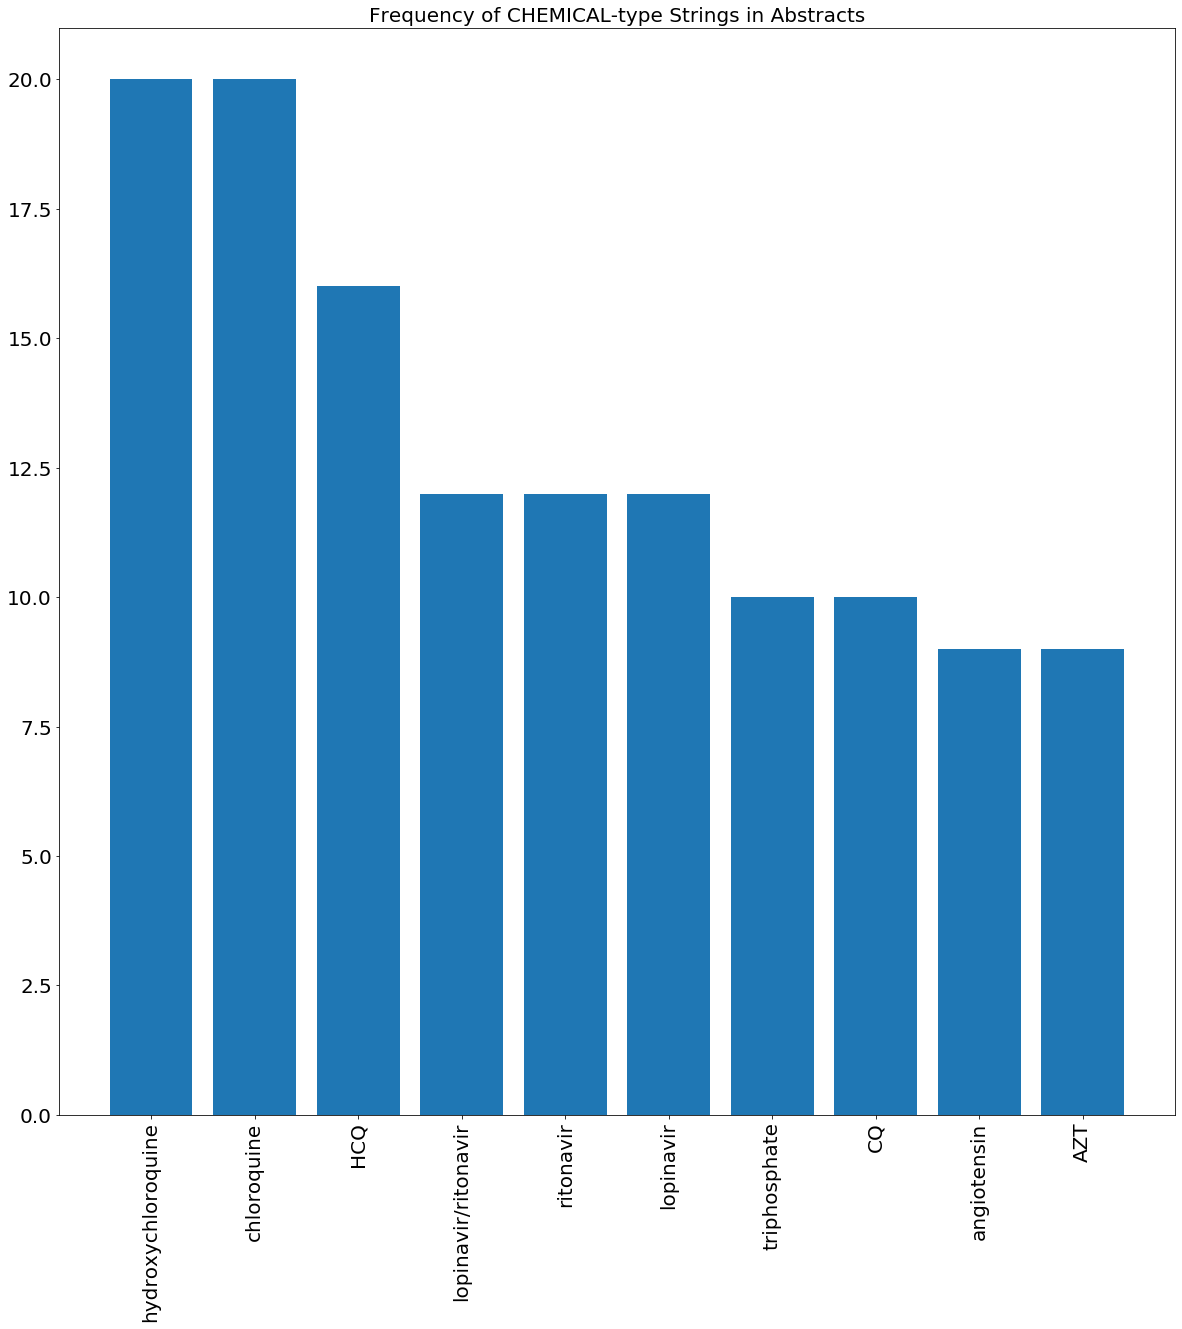

In [27]:
BLACKLIST = {
 'ACE2s',
 '2019-nCoV',
 '95%CI',
 'ACE2-Fc',
 'AMB',
 'AMI',
 'AMK',
 'AOM',
 'AST-045',
 'AST-N041',
 'ATP',
 'BPO3-P',
 'Betacoronavirus',
 'CAP',
 'CAZ',
 'CC',
 'CIP',
 'CP',
 'CLAVE',
 'COVID-2019',
 'CR3022',
 'creatinine', 
 'CTX',
 'CTX-M',
 'CoV-2',
 'DES',
 'DHPG',
 'DIP',
 'E2',
 'ESBL',
 'Enterobacteriaceae',
 'FASTA',
 'FCA',
 'FCS',
 'FOS',
 'GEN',
 'GM',
 'HK',
 'HPDI',
 'IFR',
 'IM',
 'IVA',
 'JA',
 'KLK13',
 'LA',
 'LPV/r',
 'LYM%',
 'La',
 'LcS',
 'Li',
 'MERS-CoV.',
 'MICs',
 'Metapneumovirus',
 'Médecine',
 'NAL',
 'NCP',
 'NG',
 'NLR',
 'NO',
 'NOR',
 'NP',
 'NS7b',
 'OC',
 'OFL',
 'OP',
 'Prefixes',
 'Résumé',
 'S.',
 'SARS-CoV-2',
 'SARS-COV-2',
 'SARS-Cov2',
 'SARS-CoV2',
 'SARS-CoV-2 infection',
 'SARS-CoV-2 infections',
 'SARS-CoV-2 pneumonia',
 'SARS-CoV.',
 'SARS-Cov-2',
 'SARS-related',
 'SGC7901',
 'SHV',
 'SP',
 'Sarbecovirus',
 'Se',
 'TCM',
 'TCR',
 'TCB',
 'TGEV',
 'TOB',
 'TSL-EO',
 'Texte',
 'VME',
 'VP',
 'WeChat',
 'ZJ01',
 '[ST]A',
 'alcohol',
 'amino acid',
 'amino acids',
 'aminoglycosides',
 'bat-SL-CoVZXC21',
 'betacoronavirus',
 'cholesterol',
 'coronavirus',
 'des cas',
 'https://doi.org/10',
 'infector-infectee',
 "l'origine",
 'lactate',
 'lockdowns',
 'na',
 'nucleic acid',
 'nucleic acids',
 'nucleotide',
 'NBCZone',
 'oxygen',
 'quinolones',
 'rinitis',
 'self-imposed',
 'sodium',
 'smoking',
 'β-coronavirus',
 '℃'}


def count_chemical_ents(df):
    ent_str = []
    for i, row in df.iterrows():
        if row.abstract_doc:            
            for ent in row.abstract_doc.ents:
                if ent.label_ == 'CHEMICAL':
                    ent_str.append(row.abstract_doc[ent.start:ent.end].text)
            
    filtered = [e for e in Counter(ent_str).most_common() if e[1] > 8 and e[0] not in BLACKLIST]
    return dict(filtered)

counts = count_chemical_ents(df_with_matches)
print('Count Frequencies\n')
print(counts)

plt.figure(figsize=(20,20))
plt.rc('xtick', labelsize=20) 
plt.rc('ytick', labelsize=20) 
plt.xticks(rotation=90)
plt.title('Frequency of CHEMICAL-type Strings in Abstracts', fontsize=20)
plt.bar(counts.keys(), counts.values())

In [28]:
import ipywidgets as widgets
from ipywidgets import interact, interact_manual
from IPython.core.display import HTML

HTML_WRAPPER = """<div style="overflow-x: auto; border: 1px solid #e6e9ef; border-radius: 0.25rem; padding: 1rem; margin-bottom: 2.5rem">{}</div>"""
BEGIN_ENTITY = """<mark class="entity" style="background: lightpink; padding: 0.45em 0.6em; margin: 0 0.25em; line-height: 1; border-radius: 0.35em;">"""
END_ENTITY = """</mark>"""

def match_to_concordance_html(match, doc, window_size=15):
    _, start, end = match
    concordance_start = max(start - window_size, 0)
    concordance_end = min(end + window_size, len(doc))
    return doc[concordance_start:start].text + BEGIN_ENTITY + doc[start:end].text + END_ENTITY + doc[end:concordance_end].text + '</br></br>'

@interact_manual
def show_articles_more_than(column='abstract_doc', query='darunavir'):
    matcher = Matcher(nlp.vocab)
    matcher.add("query", None, [{'LEMMA': w.lemma_} for w in nlp(query)])
    result = []
    html_str = ''
    for doc in df_with_matches[column]:
        if not doc:
            continue
        matches = matcher(doc)
        for match in matches:
            html_str += match_to_concordance_html(match, doc)
    return display(HTML(HTML_WRAPPER.format(html_str + ''))) ##


interactive(children=(Text(value='abstract_doc', description='column'), Text(value='darunavir', description='q…

In [29]:
def doc_id_to_link(doc_id, df_meta, df_data):
    rows = df_meta[df_meta.sha == doc_id]
    if rows.empty:
        return 'UNKNOWN URL AND TITLE'
    url = rows.iloc[0].url
    title = rows.iloc[0].title
    if url and title:
        return '<a href="{}">'.format(url) + title + '</a>'
    elif title:
        return title
    elif url:
        return '<a href="{}">'.format(url) + 'UNKNOWN TITLE' + '</a>'
    else:
        return 'UNKNOWN URL AND TITLE'

def chemical_df(chemicals, df_data, df_meta):
    rows = []    
    for chem in chemicals:
        chem_row = {
            'chemical_name': chem,
            'chemical': [],
            'trials': [],
            'usages': [],
            'ideas': []
        }
        matcher = Matcher(nlp.vocab)
        matcher.add("query", None, [{'LEMMA': w.lemma_} for w in nlp(chem)])
        for i, row in df_data.iterrows():
            chem_matches = matcher(row.abstract_doc)
            for chem_match in chem_matches:
                chem_row['chemical'].append((row.doc_id, chem_match[1], chem_match[2]))
                for trial_match in row.abstract_trial_matches:
                    if abs(trial_match[1] - chem_match[1]) < 15:
                        chem_row['trials'].append((row.doc_id, trial_match[0], trial_match[1]))
                for usage_match in row.abstract_usage_matches:
                    if abs(usage_match[1] - chem_match[1]) < 15:
                        chem_row['usages'].append((row.doc_id, usage_match[0], usage_match[1]))
                for idea_match in row.abstract_idea_matches:
                    if abs(idea_match[1] - chem_match[1]) < 15:
                        chem_row['ideas'].append((row.doc_id, idea_match[0], idea_match[1]))
        rows.append(chem_row)
    return pd.DataFrame(rows)
        
    
df_chemical = chemical_df(list(counts.keys()), df_with_matches, df_meta)
df_chemical.head(3)

,chemical_name,chemical,trials,usages,ideas
0,hydroxychloroquine,"[(f10fb0ee869f01e39652ca0079888562e865b0ea, 77...","[(f10fb0ee869f01e39652ca0079888562e865b0ea, 71...","[(db9b9f34fb37dfbeef7e0e900e834e982536de56, 33...","[(db9b9f34fb37dfbeef7e0e900e834e982536de56, 49..."
1,chloroquine,"[(db9b9f34fb37dfbeef7e0e900e834e982536de56, 46...","[(db9b9f34fb37dfbeef7e0e900e834e982536de56, 46...","[(db9b9f34fb37dfbeef7e0e900e834e982536de56, 45...","[(db9b9f34fb37dfbeef7e0e900e834e982536de56, 49..."
2,HCQ,[],[],[],[]


In [30]:
LABEL_TO_COLOUR = {
    'chemical': 'lightorange',
    'trials': 'lightpink',
    'usages': 'lightgreen',
    'ideas': 'lightblue'
}
BEGIN_ENTITY = """<mark class="entity" style="background: {}; padding: 0.45em 0.6em; margin: 0 0.25em; line-height: 1; border-radius: 0.35em;">"""
END_ENTITY_WITH_SUBSCRIPT = """<span style="font-size: 0.8em; font-weight: bold; line-height: 1; border-radius: 0.35em; text-transform: uppercase; vertical-align: middle; margin-left: 0.5rem">{}</span>\n</mark>"""

def get_ents_by_doc_id(row):
    contexts={'chemical', 'trials', 'usages', 'ideas'}
    ents_by_doc_id = {}
    for c in contexts:
        for doc_id, start, end in row[c]:
            entry = (start, end, c)
            if doc_id not in ents_by_doc_id:
                ents_by_doc_id[doc_id] = [entry]
            else:
                ents_by_doc_id[doc_id].append(entry)
    return ents_by_doc_id

@interact
def show_articles_for_chemical(chemical=list(counts.keys())):
    row = df_chemical[df_chemical['chemical_name'] == chemical].iloc[0]
    ents_by_doc_id = get_ents_by_doc_id(row)
    html = ''
    for doc_id, ents in ents_by_doc_id.items():
        doc = df_with_matches[df_with_matches.doc_id == doc_id].iloc[0].abstract_doc
        sorted_ents = sorted(set(ents))
        doc_html = doc_id_to_link(doc_id, df_meta, df_covid19) + '</br></br>' 
        prev_end = 0
        for start, end, label in sorted_ents:
            doc_html += doc[prev_end:start].text
            doc_html += ' ' + BEGIN_ENTITY.format(LABEL_TO_COLOUR[label]) + doc[start:end].text + END_ENTITY_WITH_SUBSCRIPT.format(label) + ' '
            prev_end = end
        doc_html += doc[end:].text + '</br></br>'
        html+=doc_html
        

    return display(HTML(html))

interactive(children=(Dropdown(description='chemical', options=('hydroxychloroquine', 'chloroquine', 'HCQ', 'l…

In [33]:
# function to draw the molecule
def drawit(m,p,confId=-1):
    mb = Chem.MolToMolBlock(m,confId=confId)
    p.removeAllModels()
    p.addModel(mb,'sdf')
    p.setStyle({'stick':{}})
    p.setBackgroundColor('0xeeeeee')
    p.zoomTo()
    return p.show()
p = py3Dmol.view(width=400,height=400)

In [34]:
# get the top drugs most mencioned
listchemicals = df_chemical.chemical_name.replace('lopinavir/ritonavir', 'lopinavir').head(25)
listchemicals

0    hydroxychloroquine
1           chloroquine
2                   HCQ
3             lopinavir
4             ritonavir
5             lopinavir
6          triphosphate
7                    CQ
8           angiotensin
9                   AZT
Name: chemical_name, dtype: object

In [40]:
# # Create clusters
# listMols2 = []
# listValids = []

# for i in range(len(listchemicals)):
#     try:
#         productName = listchemicals[i]
        
#         # Initiate Chembl database client
#         molecule = new_client.molecule
#         # get the moelcule id
#         molecule_chembl_id = molecule.search(productName)[0]['molecule_chembl_id']
#         res = molecule.get(molecule_chembl_id)
#         # return smile format molecular structure
#         smileStruct = res['molecule_structures']['canonical_smiles']
#         # converto to mol format
#         m = Chem.MolFromSmiles(smileStruct)
#         m = Chem.AddHs(m)
#         listMols2.append(m)
#         listValids.append(productName)
      
#     except Exception as e:
#         print(f'\nSorry, impossible to create structure for {productName}.')
        
        
# # generate fingeprints: Morgan fingerprint with radius 2
# n_dimensions = 300
# fps = [AllChem.GetMorganFingerprintAsBitVect(m, 2, n_dimensions) for m in listMols2]
# # Convert to numpy array
# np_fps = np.asarray(fps)

# ############# PCA decomposition (n=3)  #######################
# centers = [[1, 1], [-1, -1], [1, -1]]
# X = np_fps
# pca = decomposition.PCA(n_components=3)
# pca.fit(X)
# X = pca.transform(X)
# df2 = pd.DataFrame(X ,columns=['principal_component_1','principal_component_2','principal_component_3'])
# df2['names'] = pd.DataFrame(listValids)

# ############# Kmeans clusters  #######################
# kmeansmodel = KMeans(n_clusters=8).fit(df2[df2.columns[0:3]])
# labelKmeans = kmeansmodel.labels_.astype(float)
# df2['cluster'] = labelKmeans

In [41]:
# # Remove duplicated compounds
# df2 = df2.drop_duplicates(subset=['principal_component_1','principal_component_2','principal_component_3'])
# df2.sort_values(by=['cluster'])

In [ ]:
# Gabarge collector to liberate memory
gc.collect()

In [ ]:
# ############# Scatter plot  #######################
# import matplotlib.patches as mpatches

# centroids  = kmeansmodel.cluster_centers_

# def randrange(n, vmin, vmax):
#     return (vmax - vmin)*np.random.rand(n) + vmin

# fig = plt.figure(figsize=(12, 12))
# ax = fig.add_subplot(111)

# xs = df2.principal_component_1
# ys = df2.principal_component_2
# names = df2.names
# cluster = df2.cluster
# ax.scatter(xs, ys)
# radius = 1.1

# for x,y,names,cluster in zip(xs,ys,names,cluster):
#     label = names
#     if cluster == 0:
#         ax.text(x, y, label, fontsize=12, color='red')
#         art = mpatches.Circle(centroids[0],radius, edgecolor='r',fill=False)
#         ax.add_patch(art)
#     if cluster == 1:
#         ax.text(x, y, label,fontsize=12, color='blue')
#         art = mpatches.Circle(centroids[1],radius, edgecolor='blue',fill=False)
#         ax.add_patch(art)        
#     if cluster == 2:
#         ax.text(x, y, label, fontsize=12, color='green')
#         art = mpatches.Circle(centroids[2],radius, edgecolor='green',fill=False)
#         ax.add_patch(art)        
#     if cluster == 3:
#         ax.text(x, y, label, fontsize=12, color='black') 
#         art = mpatches.Circle(centroids[3],radius, edgecolor='black',fill=False)
#         ax.add_patch(art)        
#     if cluster == 4:
#         ax.text(x, y, label, fontsize=12, color='purple')
#         art = mpatches.Circle(centroids[4],radius, edgecolor='purple',fill=False)
#         ax.add_patch(art)        
#     if cluster == 5:
#         ax.text(x, y, label, fontsize=12, color='blueviolet') 
#         art = mpatches.Circle(centroids[5],radius, edgecolor='blueviolet',fill=False)
#         ax.add_patch(art)        
#     if cluster == 6:
#         ax.text(x, y, label, fontsize=12, color='brown') 
#         art = mpatches.Circle(centroids[6],radius, edgecolor='brown',fill=False)
#         ax.add_patch(art)        
#     if cluster == 7:
#         ax.text(x, y, label, fontsize=12, color='magenta')  
#         art = mpatches.Circle(centroids[7],radius, edgecolor='magenta',fill=False)
#         ax.add_patch(art)        
    
      

# ax.set_xlabel('principal component 1')
# ax.set_ylabel('principal component 2')
# plt.title('Clusters of the most cited compounds according to their molecular structure.', loc='center', pad=None, fontSize=16)
# plt.show()

In [ ]:
# # get the top drugs most mencioned
# listchemicals = listchemicals.head(6)
# listchemicals

In [ ]:
# percentSimilarity = 85

# def print_structures(productName):
#     try:

#         print('\n..................................................................................')
#         print(f'\nStructure of {productName}\n')

#         ################## Find the molecular structure in Chembl database ###########################

#         # Initiate Chembl database client
#         molecule = new_client.molecule
#         # get the moelcule id
#         molecule_chembl_id = molecule.search(productName)[0]['molecule_chembl_id']
#         res = molecule.get(molecule_chembl_id)
#         # return smile format molecular structure
#         smileStruct = res['molecule_structures']['canonical_smiles']
#         # converto to mol format using RDKIT library
#         m = Chem.MolFromSmiles(smileStruct)
#         m = Chem.AddHs(m)
#         # create the molecule image
#         AllChem.EmbedMultipleConfs(m,randomSeed=0xf00d,useExpTorsionAnglePrefs=True, useBasicKnowledge=True)
#         interact(drawit, m=fixed(m),p=fixed(p));

#         ############ Find similar molecules in Chembl database ###################################### 
#         print(f'\nMolecules that have at least {percentSimilarity}% similarity with {productName}\n')

#         similarity = new_client.similarity
#         similar = similarity.filter(chembl_id=molecule_chembl_id, similarity=percentSimilarity)

#         list_mols=[]
#         list_ref_name = []

#         for i in range(len(similar)):

#             ref_name = (similar[i]['pref_name'])
#             if ref_name is None:
#                 ref_name = similar[i]['molecule_chembl_id']
#     #             print(ref_name)
#             smileStruct = Chem.MolFromSmiles(similar[i]['molecule_structures']['canonical_smiles'])
#             list_mols.append(smileStruct)
#             list_ref_name.append(ref_name)

#         ms = [x for x in list_mols if x is not None]

#         for m in ms: tmp=AllChem.Compute2DCoords(m)

#         img=Draw.MolsToGridImage(ms, molsPerRow=3,subImgSize=(200,200),legends=[x for x in list_ref_name])
        
#         fileName = 'related_' + productName + '.png'
#         img.save(fileName)
#         image = cv2.imread(fileName)        

#         plt.figure(figsize=(20, 80))
#         plt.ticklabel_format(style = 'plain')
#         plt.axis('off')
#         plt.imshow(image)
#         plt.show()

#     except Exception as e:
#         print('\nSorry, structure not found in Chembl database.')

In [ ]:
# print(listchemicals[0])
# print_structures(listchemicals[0])

In [ ]:
# print(listchemicals[2])
# print_structures(listchemicals[2])

In [ ]:
# print(listchemicals[3])
# print_structures(listchemicals[3])